<a id='FEMB'></a>

# Restaurant Fake Review Detection # 3

- __[Feature Engineering](#FE)__
- __[Model Building](#MB)__

    - [Text Analysis (CNN, LSTM)](#TA)

    - [Classification Algorithms](#CA)
    
    
To navigate to each section and subsection, please use this [link](https://nbviewer.jupyter.org/github/sjung-stat/Fake-Review-Detection/blob/main/Feature_Engineering_and_Model_Building.ipynb) where you can use embedded internal links within this notebook. 

<a id='FE'></a>

# Feature Engineering

In [1]:
# Import libraries required for analysis

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
df_join = pd.read_pickle("./org_df.pkl")

In [3]:
# Find out the maximum number of reviews each reviewer has left in a day and drop the reviewerID.

max_temp = df_join.groupby(['reviewerID','date'])['reviewerID'].count().reset_index(name='count')
max_temp_new = max_temp.groupby("reviewerID", as_index = False).max()

df_join = pd.merge(df_join,
                 max_temp_new[['reviewerID', 'count']],
                 on='reviewerID')
df_join.rename({'count': 'maxReview_a_day'}, axis=1, inplace=True)  # rename the count column

In [4]:
# Reviews left by a reviewer whose maxReview_a_day = 12

max_review = df_join.loc[df_join['maxReview_a_day'].idxmax()].reviewerID   
df_join.loc[df_join['reviewerID']==max_review, df_join.columns != 'reviewerID']

,date,reviewContent,rating,flagged,reviewer_location,yelpJoinDate,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,reviewer_usefulCount,reviewer_coolCount,reviewer_funnyCount,reviewer_complimentCount,reviewer_tipCount,reviewer_fanCount,restaurant_reviewCount,restaurant_rating,categories,PriceRange,maxReview_a_day
7226,2012-04-12,probably the best meal i have ever had everyth...,5,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,841,4.5,"Restaurants, American (New)",Over $61,12
7227,2012-04-12,great atmosphere nice wines try the homemade r...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,578,4.0,"Restaurants, Italian",$11-30,12
7228,2012-04-12,very good homemade pasta wonderful outdoor sea...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,481,4.0,"Restaurants, Italian",$31-60,12
7229,2012-04-12,their pizza is very good i dont like their atm...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,1543,4.0,Other,$11-30,12
7230,2012-04-12,great sandwiches worth the quickly moving line...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,1461,4.0,"Restaurants, Mexican",$11-30,12
7231,2012-04-12,my favorite chinese restaurant in chicago best...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,607,4.0,"Restaurants, Chinese",$11-30,12
7232,2012-04-12,i started out liking this place much more but ...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,947,4.0,Other,$11-30,12
7233,2012-04-12,this place is steady its got a nice fun atmosp...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,702,4.0,Other,$31-60,12
7234,2012-04-12,uninspired nice atmosphere and service but the...,3,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,581,4.0,"Restaurants, American (New)",Over $61,12
7235,2012-04-12,if you can get over the occasionally terrible ...,4,N,"Chicago, IL",2006-01,8,48,0,7,2,2,0,0,0,684,3.5,Other,$11-30,12


In [5]:
# Calcuate the standard deviation of ratings of each reviewer.

meansd = df_join.groupby(['reviewerID'], as_index=False).agg({'rating':['std']})
meansd.columns = ['reviewerID', 'rating_std']
df_join = pd.merge(df_join, meansd[['reviewerID', 'rating_std']], on='reviewerID')

df_join['rating_std'] = df_join['rating_std'].fillna(0)

In [6]:
# Calculate the time differences between 'date' and 'yelpJoinDate', and remove 'yelpJoinDate' and 'date_mo_yr'. 

df_join['date_mo_yr'] = pd.to_datetime(df_join['date']).dt.to_period('M')
df_join['sinceJoin_months'] = (df_join['date_mo_yr'] - df_join['yelpJoinDate']).apply(attrgetter('n'))

df_join = df_join.drop(['yelpJoinDate', 'date_mo_yr'], axis=1)

In [7]:
# Count the number of words and uppercase letters in each reviewContent.

df_join['wordCount'] = df_join.reviewContent.apply(lambda x: len(x.split()))
df_join['uppercaseCount'] = df_join.reviewContent.apply(lambda x: sum(1 for c in x if c.isupper()))

Most of the reviewers are in Chicago, IL. Rather than having all infrequent location information, create a new column 'reviewer_restaurant_loc_match' to indicate whether reviewers are in Chicago or not as the restaurants in this dataset are in the Chicago area. 

In [8]:
# Rename 'reviewer_location' to 'reviewer_restaurant_loc_match'
df_join.rename(columns = {'reviewer_location':'reviewer_restaurant_loc_match'}, inplace = True)

# Compare reviewer's location & restuarant location (Chicago, IL) and see if they match (Y/N)
for i in range(df_join.shape[0]):
    if df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] == 'Chicago, IL':
        df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] = 'Y'
    else:
        df_join.loc[df_join.index[i], 'reviewer_restaurant_loc_match'] = 'N'

In [9]:
# Create two columns (polarity and subjectivity) using sentiment analysis with review contents.

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_join["polarity"] = df_join["reviewContent"].apply(pol)
df_join["subjectivity"] = df_join["reviewContent"].apply(sub)

The 'reviewer_usefulCount', 'reviewer_coolCount', 'reviewer_funnyCount', 'reviewer_complimentCount', 'reviewer_tipCount' have very high correlations with each other. Hence, we create a new feature 'reviewer_upvoteCount' by summing the above features, and drop them to avoid multicolliearity.

In [10]:
# Drop columns to avoid multicolliearity. 

df_join['reviewer_upvoteCount'] = df_join['reviewer_usefulCount'] + df_join['reviewer_coolCount'] + df_join['reviewer_funnyCount'] + df_join['reviewer_complimentCount'] + df_join['reviewer_tipCount']
df_join = df_join.drop(['reviewer_usefulCount', 'reviewer_coolCount', 'reviewer_funnyCount', 'reviewer_complimentCount', 'reviewer_tipCount'], axis=1)

Also, the 'reviewer_fanCount' and 'reviewer_friendCount' have a correlation of 0.89. Both of them represent the number of connections of each reviewer. We keep the 'reviewer_friendCount' and drop the 'reviewer_fanCount'.

In [11]:
# Drop the 'reviewer_fanCount'.

df_join = df_join.drop(['reviewer_fanCount'], axis=1)

In [12]:
# Create 'month', 'day', 'weekday' columns using the 'date' column. 

df_join['month'] = df_join.date.dt.month
df_join['day'] = df_join.date.dt.day
df_join['weekday'] = df_join.date.dt.day_name()

In [13]:
# Lastly, drop 'reviewerID' and 'date'. 

df_join = df_join.drop(['reviewerID', 'date'], axis=1)

In [14]:
# One Hot Encoding (3 attributes)
df_encoded = pd.get_dummies(data=df_join, columns=['categories', 'PriceRange', 'weekday'])



# Label Encoding (1 attribute, 1 class)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_encoded['reviewer_restaurant_loc_match'] = le.fit_transform(df_encoded.reviewer_restaurant_loc_match.values)

le = preprocessing.LabelEncoder()
df_encoded['flagged'] = le.fit_transform(df_encoded.flagged.values)


Now we have 37 attributes including the response with approximately 27,000 reviews. 

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26956 entries, 0 to 26955
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   reviewContent                            26956 non-null  object 
 1   rating                                   26956 non-null  int64  
 2   flagged                                  26956 non-null  int32  
 3   reviewer_restaurant_loc_match            26956 non-null  int32  
 4   reviewer_friendCount                     26956 non-null  int64  
 5   reviewer_reviewCount                     26956 non-null  int64  
 6   reviewer_firstCount                      26956 non-null  int64  
 7   restaurant_reviewCount                   26956 non-null  int64  
 8   restaurant_rating                        26956 non-null  float64
 9   maxReview_a_day                          26956 non-null  int64  
 10  rating_std                               26956

In [16]:
# Split data into training and test sets.

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = df_encoded.drop(['flagged'], axis=1)
Y = df_encoded['flagged'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(20217, 37) (6739, 37) (20217,) (6739,)


In [17]:
# Separate 'reviewContent' from the training and test sets.

X_train_num_cat = X_train.drop('reviewContent', axis=1)
X_train_text = X_train['reviewContent'].copy()

X_test_num_cat = X_test.drop('reviewContent', axis=1)
X_test_text = X_test['reviewContent'].copy()

In [18]:
# Feature scaling (min-max sclaing)

from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

minmaxscale = MinMaxScaler()

col_names = X_train_num_cat.columns

X_train_num_cat_scaled = minmaxscale.fit_transform(X_train_num_cat)
X_train_num_cat_scaled = DataFrame(X_train_num_cat_scaled, columns = col_names)

X_test_num_cat_scaled = minmaxscale.transform(X_test_num_cat)
X_test_num_cat_scaled = DataFrame(X_test_num_cat_scaled, columns = col_names)

In [19]:
X_train_num_cat_scaled.head()

,rating,reviewer_restaurant_loc_match,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,restaurant_reviewCount,restaurant_rating,maxReview_a_day,rating_std,sinceJoin_months,...,PriceRange_$31-60,PriceRange_Over $61,PriceRange_Under $10,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.50,0.0,0.002975,0.020307,0.003476,0.268339,0.000000,0.0,0.000000,0.317647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00,1.0,0.000000,0.005364,0.001159,0.443919,0.333333,0.0,0.000000,0.352941,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.00,1.0,0.001275,0.039847,0.002317,0.191197,0.333333,0.0,0.350382,0.047059,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.75,1.0,0.002125,0.001149,0.000000,0.426881,0.333333,0.0,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.75,1.0,0.000000,0.007280,0.002317,0.158069,0.333333,0.0,0.000000,0.564706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test_num_cat_scaled.head()

,rating,reviewer_restaurant_loc_match,reviewer_friendCount,reviewer_reviewCount,reviewer_firstCount,restaurant_reviewCount,restaurant_rating,maxReview_a_day,rating_std,sinceJoin_months,...,PriceRange_$31-60,PriceRange_Over $61,PriceRange_Under $10,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.75,1.0,0.010625,0.172031,0.022016,0.327970,0.333333,0.090909,0.253546,0.411765,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.00,0.0,0.024012,0.052490,0.030127,0.191197,0.333333,0.000000,0.000000,0.152941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.00,0.0,0.003612,0.062835,0.013905,0.323237,0.333333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.00,1.0,0.000000,0.001916,0.000000,0.287269,0.333333,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.50,0.0,0.000425,0.005364,0.000000,0.323237,0.333333,0.000000,0.000000,0.011765,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<a id='MB'></a>

# Model Building

In [21]:
print("Total number of genuine reviews: ", np.count_nonzero(Y == 0), "\nTotal number of fake reviews: ", np.count_nonzero(Y == 1), "\nBaseline model (initial guess) - Accuracy: ", round(np.count_nonzero(Y == 0) / Y.shape[0], 4) * 100, '%')

Total number of genuine reviews:  20750 
Total number of fake reviews:  6206 
Baseline model (initial guess) - Accuracy:  76.98 %


<a id='TA'></a>

## Text Analysis (Natural Language Processing & Deep Learning)

My original idea was to build a classifier using only text data (reviewContent) with Natural Language Processing and Deep Learning techniques, and add the binary outcomes (Fake / Genuine) to the original dataset as a new column, so that I can take into account the raw text data, in addition to the characteristics of text data (word count, polarity score, uppercase letter count, etc). 

Unfortunately, the text classifier is overfitting even after numerous attempts to resolve the problem by dropping out nodes, adjusting embedding size, etc. So the outcome from this classifier will not be used since the results would negatively affect the performance if the new feature is added to the original dataset. 

But I am leaving the code/results in this notebook so I can come back to this later and retry improving it, or get feedbacks from other experts. 

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM

# Tokenization - train
docs_train = X_train_text.astype(str).values.tolist()
token = Tokenizer(num_words = 500)
token.fit_on_texts(docs_train)
X_train_seq = token.texts_to_sequences(docs_train)

# Padding (make each list of the same length) - train
padded_X_train = pad_sequences(X_train_seq, 100)

In [23]:
# Tokenization & Padding - test
docs_test = X_test_text.astype(str).values.tolist()
x_test_seq = token.texts_to_sequences(docs_test)
padded_X_test = pad_sequences(x_test_seq, 100) 

Epoch 1/10
203/203 [==============================] - 21s 96ms/step - loss: 0.5154 - accuracy: 0.7689 - val_loss: 0.5003 - val_accuracy: 0.7685
Epoch 2/10
203/203 [==============================] - 18s 91ms/step - loss: 0.4870 - accuracy: 0.7717 - val_loss: 0.5113 - val_accuracy: 0.7704
Epoch 3/10
203/203 [==============================] - 19s 94ms/step - loss: 0.4781 - accuracy: 0.7759 - val_loss: 0.5162 - val_accuracy: 0.7457
Epoch 4/10
203/203 [==============================] - 20s 97ms/step - loss: 0.4662 - accuracy: 0.7809 - val_loss: 0.5058 - val_accuracy: 0.7598
Epoch 5/10
203/203 [==============================] - 20s 96ms/step - loss: 0.4546 - accuracy: 0.7867 - val_loss: 0.5026 - val_accuracy: 0.7626
Epoch 6/10
203/203 [==============================] - 20s 98ms/step - loss: 0.4338 - accuracy: 0.7976 - val_loss: 0.5186 - val_accuracy: 0.7437
Epoch 7/10
203/203 [==============================] - 20s 100ms/step - loss: 0.4050 - accuracy: 0.8111 - val_loss: 0.5767 - val_accuracy

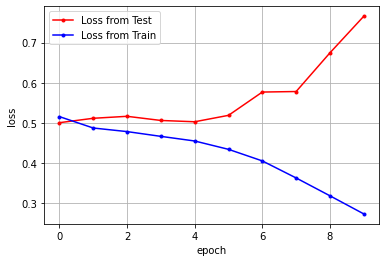

In [24]:
# Using CNN and LSTM
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Embedding(500, 100))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(300))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

record = model.fit(padded_X_train, Y_train, batch_size=100, epochs=10, validation_data=(padded_X_test, Y_test))
print("\n Accuracy: %.4f" % (model.evaluate(padded_X_test, Y_test)[1]))


Y_val_loss = record.history['val_loss']
Y_loss = record.history['loss']
X_len = numpy.arange(len(Y_loss))
plt.plot(X_len, Y_val_loss, marker='.', c="red", label="Loss from Test")
plt.plot(X_len, Y_loss, marker='.', c="blue", label="Loss from Train")

plt.legend(loc="upper left")
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<a id='CA'></a>

## Classification Algorithms

For classification problems, there are several metrics in addition to accuracy, which can be used to evaluate classifiers, such as recall and precision.


- Recall = $\frac{TP}{TP + FN}$

- Precision = $\frac{TP}{TP + FP}$


where TP: true positive, FP: false positive, and FN: false negative which can be obtained from confusion matrix. 

The relative importance of recall and precision dependes on situations. In the context of this problem where the goal is to filter out fake reviews and hide them from other users, it would be better to show only genuine reviews even if some of genuine reviews could be filtered out due to classifiers' errors, than failing to filter out fake reviews and letting other users to see them because a single review could bring a negative effect to businesses and customers. In this case, high precision is desired instead of high recall. So in addition to accuracy, I put more weight on precision than recall. 

The following is the summary of the classification results based on 10-fold cross validations:

- [XGBoost](#XGB) (Accuracy: 90.5% / Precision: 80.1% / Recall: 77.8%)
- [Random Forest](#RF) (Accuracy: 88.3% / Precision: 78.1% / Recall: 67.8%)
- [Neural Networks](#NN) (Accuracy: 87.3% / Precision: 72.9% / Recall: 70.1%)
- [Logistic Regression](#LR) (Accuracy: 84.9% / Precision: 70.7% / Recall: 58.7%)
- [Support Vector Machine](#SVM) (Accuracy: 82.8% / Precision: 71.2% / Recall: 42.7%)
- [SGD Classifier](#SGD) (Accuracy: 82.5% / Precision: 67.2% / Recall: 46.8%)

The three models that give the best results are selected for hyperparameter tunings to improve the performance. Also, XGBoost and random forest are combined using soft voting to make a single classifier. The new model has the following classification results based on 10-fold cross validation:

- [Soft Voting (XGBoost & Random Forest)](#SV) (Accuracy: 90.7% / Precision: 81.1% / Recall: 77.5%)

Finally, we observe the feature importance plots generated by XGBoost and random forest [here](#FI). 

In [25]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier

In [26]:
def prec_rec_threshold(precisions, recalls, thresholds):
    """
    Plot precisions and recalls based on thresholds
    """
    
    plt.plot(thresholds, precisions[:-1], 'g--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'y-', label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

<a id='XGB'></a>

### XGBoost (Accuracy: 90.5% / Precision: 80.1% / Recall: 77.8%)

In [27]:
# 10-fold Cross Validation

xgb_cl = xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='error', use_label_encoder=False)
xgb_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [28]:
print("Accuracy: ", np.mean(cross_val_score(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.9045353413294924
Precision:  0.8005754758742807
Recall:  0.7785191562634525


In [29]:
# Hyperparameter Tuning (1st)
# Tune 'max_depth' and 'min_child_weight' with wide steps

xgb_cl = xgb.XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_1 = {
    'max_depth': range(1, 10, 2),
    'min_child_weight' : range(1, 8, 2)
}

grid_search_1 = GridSearchCV(estimator = xgb_cl, param_grid = param_1, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_1.fit(X_train_num_cat_scaled, Y_train)
grid_search_1.best_params_, grid_search_1.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'max_depth': 5, 'min_child_weight': 3}, 0.9055745077704488)

In [30]:
# Hyperparameter Tuning (2nd)
# Tune 'max_depth' and 'min_child_weight' with small steps

xgb_cl = xgb.XGBClassifier(learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_2 = {
    'max_depth': [4,5,6],
    'min_child_weight' : [2,3,4]
}

grid_search_2 = GridSearchCV(estimator = xgb_cl, param_grid = param_2, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_2.fit(X_train_num_cat_scaled, Y_train)
grid_search_2.best_params_, grid_search_2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'max_depth': 5, 'min_child_weight': 2}, 0.9060196727904992)

In [31]:
# Hyperparameter Tuning (3rd)
# Tune 'gamma' 

xgb_cl = xgb.XGBClassifier(max_depth = 5, min_child_weight = 2, 
                           learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_3 = {
    'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4]
}

grid_search_3 = GridSearchCV(estimator = xgb_cl, param_grid = param_3, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_3.fit(X_train_num_cat_scaled, Y_train)
grid_search_3.best_params_, grid_search_3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({'gamma': 0.0}, 0.9060196727904992)

In [32]:
# Hyperparameter Tuning (4th)
# Tune 'subsample' and 'colsample_bytree'

xgb_cl = xgb.XGBClassifier(gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           learning_rate = 0.1, objective= 'binary:logistic', n_estimators = 180, 
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_4 = {
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_search_4 = GridSearchCV(estimator = xgb_cl, param_grid = param_4, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_4.fit(X_train_num_cat_scaled, Y_train)
grid_search_4.best_params_, grid_search_4.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'colsample_bytree': 0.5, 'subsample': 1.0}, 0.9064153084313953)

In [33]:
# Hyperparameter Tuning (5th)
# Tune 'subsample' and 'colsample_bytree' 

xgb_cl = xgb.XGBClassifier(colsample_bytree = 0.5, subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_5 = {
    'n_estimators' : [160, 170, 180, 190, 200],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.3]
}

grid_search_5 = GridSearchCV(estimator = xgb_cl, param_grid = param_5, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_5.fit(X_train_num_cat_scaled, Y_train)
grid_search_5.best_params_, grid_search_5.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


({'learning_rate': 0.15, 'n_estimators': 180}, 0.9082950395024018)

In [34]:
# Hyperparameter Tuning (6th)
# Tune 'subsample' and 'colsample_bytree' 

xgb_cl = xgb.XGBClassifier(colsample_bytree = 0.5, subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, 
                           objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
param_6 = {
    'n_estimators' : [170, 175, 180],
    'learning_rate' : [0.13, 0.14, 0.15, 0.16, 0.17]
}

grid_search_6 = GridSearchCV(estimator = xgb_cl, param_grid = param_6, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_6.fit(X_train_num_cat_scaled, Y_train)
grid_search_6.best_params_, grid_search_6.best_score_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


({'learning_rate': 0.17, 'n_estimators': 170}, 0.9083940615632201)

In [27]:
# 10-fold Cross Validation with tuned hyperparameters 

xgb_cl = xgb.XGBClassifier(learning_rate = 0.17, n_estimators = 170, colsample_bytree = 0.5, 
                           subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
xgb_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [36]:
print("Accuracy: ", np.mean(cross_val_score(xgb_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.9082450295634708
Precision:  0.8094921268573964
Recall:  0.785622040464916


Although all metrics (accuracy, precision, and recall) have increased after hyperparameter tuning, it is not a huge improvement. 

<a id='RF'></a>

### Random Forest (Accuracy: 88.3% / Precision: 78.3% / Recall: 68.0%)

In [37]:
# 10-fold Cross Validation

rnd_cl = RandomForestClassifier(n_estimators=300, max_leaf_nodes=20, n_jobs=-1, oob_score=True, max_features = "auto")
rnd_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [38]:
print("Accuracy: ", np.mean(cross_val_score(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.8830690460354214
Precision:  0.7828458106098165
Recall:  0.6797244941885493


In [39]:
# Hyperparameter Tuning (1st)

rnd_cl = RandomForestClassifier(n_jobs=-1, oob_score=True)
random_param = {'n_estimators': range(200, 1000, 100),
               'max_depth': range(10, 100, 10),
               'min_samples_split': range(2,10,1),
               'min_samples_leaf': range(1,5,1)}

random_search1 = RandomizedSearchCV(estimator = rnd_cl, param_distributions = random_param, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
random_search1.fit(X_train_num_cat_scaled, Y_train)
random_search1.best_params_, random_search1.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


({'n_estimators': 200,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_depth': 20},
 0.8950883222959515)

In [40]:
# Hyperparameter Tuning (2nd)
# Tune 'max_depth' and 'n_estimators' with small steps

rnd_cl = RandomForestClassifier(min_samples_split = 2, min_samples_leaf = 1, 
                                n_jobs=-1, oob_score=True, max_features = "auto")

param_2 = {
    'n_estimators' : range(650, 750, 10),
    'max_depth' : [45, 50, 55]
}

grid_search_2 = GridSearchCV(estimator = rnd_cl, param_grid = param_2, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=True)
grid_search_2.fit(X_train_num_cat_scaled, Y_train)
grid_search_2.best_params_, grid_search_2.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


({'max_depth': 45, 'n_estimators': 670}, 0.8960281939477032)

In [41]:
# 10-fold Cross Validation with tuned hyperparameters 

rnd_cl = RandomForestClassifier(max_depth = 45, n_estimators = 670, min_samples_split = 2, min_samples_leaf = 1, 
                                n_jobs=-1, oob_score=True, max_features = "auto")
rnd_cl.fit(X_train_num_cat_scaled, Y_train)
Y_train_pred = cross_val_predict(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10)

In [42]:
print("Accuracy: ", np.mean(cross_val_score(rnd_cl, X_train_num_cat_scaled, Y_train, cv=10, scoring='accuracy')))
print("Precision: ", precision_score(Y_train, Y_train_pred))
print("Recall: ", recall_score(Y_train, Y_train_pred))

Accuracy:  0.8963249382962573
Precision:  0.7952865064695009
Recall:  0.7408523461041756


<a id='NN'></a>

### Neural Networks (Accuracy: 88.1% / Precision: 76.9% / Recall: 69.2%)

In [114]:
def create_network():
    n_features = X_train_num_cat_scaled.shape[1]
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=n_features))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [113]:
warnings.filterwarnings("ignore")

neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=32, 
                                 verbose=0)

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(neural_network, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))

Accuracy:  0.8813862945501512
Precision:  0.7693960254217955
Recall:  0.6917361861714761


In [27]:
# Hyperparameter tuning (Random Search)

warnings.filterwarnings("ignore")

def create_network_random(neurons=15, drop_out=0.1):
    n_features = X_train_num_cat_scaled.shape[1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=n_features))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

neural_network_random = KerasClassifier(build_fn=create_network_random, verbose=0)
param_1 = {
    'batch_size' : range(40, 100, 20),
    'epochs' : range(100, 1000, 100),
    'neurons' : [15, 20, 25, 30, 35],
    'drop_out' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

random_search1 = RandomizedSearchCV(estimator = neural_network_random, param_distributions = param_1, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
random_search1.fit(X_train_num_cat_scaled, Y_train)
random_search1.best_params_, random_search1.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


({'neurons': 25, 'epochs': 700, 'drop_out': 0.3, 'batch_size': 80},
 0.8850965857505798)

In [27]:
# Hyperparameter Tuning (Grid Search based on the previous outcome)

warnings.filterwarnings("ignore")

def create_network_random(neurons=15, drop_out=0.1):
    n_features = X_train_num_cat_scaled.shape[1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=n_features))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

neural_network = KerasClassifier(build_fn=create_network_random, verbose=0)
param_2 = {
    'batch_size' : [75, 80, 85],
    'epochs' : [650, 700, 750],
    'neurons' : [23, 25, 27],
    'drop_out' : [0.25, 0.3, 0.35]
}

grid_search_1 = GridSearchCV(estimator = neural_network, param_grid = param_2, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose=2)
grid_search_1.fit(X_train_num_cat_scaled, Y_train)
grid_search_1.best_params_, grid_search_1.best_score_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


({'batch_size': 75, 'drop_out': 0.35, 'epochs': 750, 'neurons': 27},
 0.8863335855674153)

In [33]:
# 10-fold Cross Validation with tuned hyperparameters 

def create_network_do():
    n_features = X_train_num_cat_scaled.shape[1]
    model = Sequential()
    model.add(Dense(27, activation='relu', input_dim=n_features))
    model.add(Dropout(0.35))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
warnings.filterwarnings("ignore")

neural_network_do = KerasClassifier(build_fn=create_network_do, 
                                 epochs=750, 
                                 batch_size=75, 
                                 verbose=0)

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(neural_network_do, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))


Accuracy:  0.8865800783171359
Precision:  0.7662271219475117
Recall:  0.7302884599170013


<a id='LR'></a>

### Logistic Regression CV (Accuracy: 84.9% / Precision: 70.8% / Recall: 58.7%)

In [28]:
# 10-fold Cross Validation

log_cl = LogisticRegression(solver="lbfgs", C=10, max_iter=400, random_state=0)
log_cl.fit(X_train_num_cat_scaled, Y_train)

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(log_cl, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))

Accuracy:  0.8493349259090138
Precision:  0.707794323642162
Recall:  0.5871825176121617


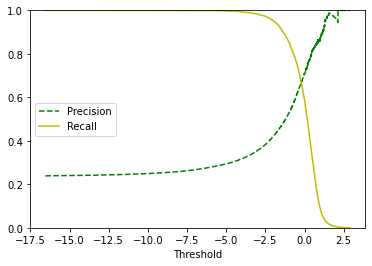

In [29]:
# Precision vs. Recall based on thresholds

Y_log_scores = cross_val_predict(log_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_log, recalls_log, thresholds_log = precision_recall_curve(Y_train, Y_log_scores)
prec_rec_threshold(precisions_log, recalls_log, thresholds_log)
plt.show()

<a id='SVM'></a>

### Support Vector Machine (Accuracy: 82.9% / Precision: 71.2% / Recall: 42.7%)

In [30]:
# 10-fold Cross validation

svm_cl=SVC(random_state=1, coef0=0, C=1, gamma= 'scale', kernel='rbf', decision_function_shape='ovo')
svm_cl.fit(X_train_num_cat_scaled, Y_train)

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(svm_cl, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))

Accuracy:  0.8285104816831772
Precision:  0.7119798739774621
Recall:  0.42660965888023733


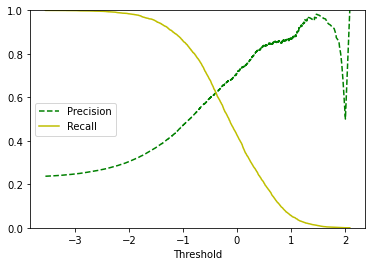

In [31]:
# Precision vs. Recall based on thresholds

Y_svm_scores = cross_val_predict(svm_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(Y_train, Y_svm_scores)
prec_rec_threshold(precisions_svm, recalls_svm, thresholds_svm)
plt.show()

<a id='SGD'></a>

### SGD Classifier (Accuracy: 82.5% / Precision: 67.4% / Recall: 46.8%) 

In [32]:
# 10-fold Cross validation

sgd_cl = SGDClassifier(max_iter=50, random_state=42)
sgd_cl.fit(X_train_num_cat_scaled, Y_train)

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(sgd_cl, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))

Accuracy:  0.8251976159328045
Precision:  0.674386603597164
Recall:  0.46819011865035226


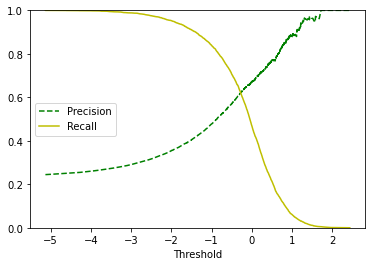

In [33]:
# Precision vs. Recall based on thresholds

Y_sgd_scores = cross_val_predict(sgd_cl, X_train_num_cat_scaled, Y_train, cv=10, method='decision_function')
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(Y_train, Y_sgd_scores)

prec_rec_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)
plt.show()

<a id='SV'></a>

### Soft Voting (Accuracy: 90.7% / Precision: 81.1% / Recall: 77.5%)

In [37]:
# Soft Voting (XGBoost and random forest)

xgb_cl = xgb.XGBClassifier(learning_rate = 0.17, n_estimators = 170, colsample_bytree = 0.5, 
                           subsample = 1.0, gamma = 0.0, max_depth = 5, min_child_weight = 2, objective= 'binary:logistic',  
                           scale_pos_weight=1, eval_metric='error', use_label_encoder=False)
rnd_cl = RandomForestClassifier(max_depth = 45, n_estimators = 670, min_samples_split = 2, min_samples_leaf = 1, 
                                n_jobs=-1, oob_score=True, max_features = "auto")

voting_cl = VotingClassifier(estimators = [('xgb', xgb_cl), ('rf', rnd_cl)], voting='soft')
voting_cl.fit(X_train_num_cat_scaled, Y_train)


for clf in (xgb_cl, rnd_cl, voting_cl):
    clf.fit(X_train_num_cat_scaled, Y_train)
    Y_pred = clf.predict(X_test_num_cat_scaled)
    print(clf.__class__.__name__, accuracy_score(Y_test, Y_pred))

XGBClassifier 0.9103724588217836
RandomForestClassifier 0.892862442498887
VotingClassifier 0.9065143196319929


In [39]:
scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'accuracy': make_scorer(accuracy_score)}

results = cross_validate(voting_cl, X_train_num_cat_scaled, Y_train, scoring = scoring, cv=10, return_train_score=True)

print("Accuracy: ", np.mean(results['test_accuracy']))
print("Precision: ", np.mean(results['test_precision']))
print("Recall: ", np.mean(results['test_recall']))

Accuracy:  0.9067117472277975
Precision:  0.8111472079585635
Recall:  0.7748642009640341


In conclusion, after the hyperparameter tuning process, XGBoost produces the best result in all three metrics (accuracy, precision, and recall), followed by random forest, and neural network. The performance of the classifiers can be further improved by finding more optimal combinations of hyperparameters. 

XGBoost and the soft voting classifier have very similar results, so either one can be the final model. However, if you care more about precision rate than accuracy and recall rate, soft voting classifier can be used as it has slightly higher precision rate. 

<a id='FI'></a>

### Feature Importance (XGBoost and Random Forest)

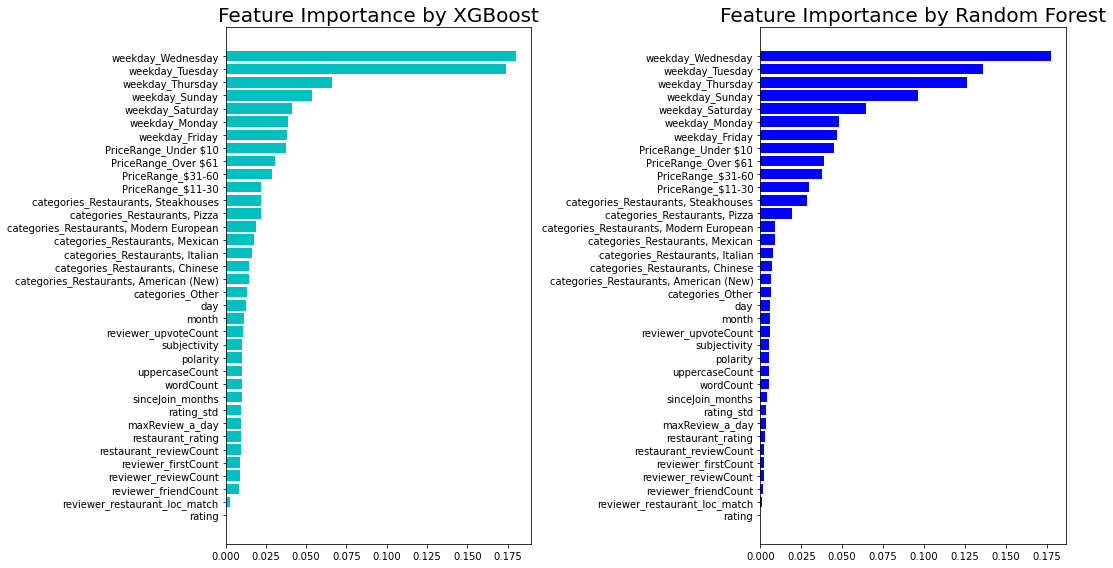

In [71]:
plt.subplots(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.barh(X_test_num_cat_scaled.columns, xgb_cl.feature_importances_[sort_col], color='c')
plt.title("Feature Importance by XGBoost", size=20)

plt.subplot(1, 2, 2)
plt.barh(X_test_num_cat_scaled.columns, rnd_cl.feature_importances_[sort_col_rf], color='b')
plt.title("Feature Importance by Random Forest", size=20)

plt.tight_layout()

The feature important plots indicate that both XGBoost and random forest have the same order of feature importances. The weekday features come on top followed by the price ranges, and types of restaurants. However, the the score of each feature is different. 